# Statistical modeling using numpyro

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import jax
import numpyro
import numpyro.distributions as dist
import arviz as az

from numpyro.examples.datasets import LYNXHARE, load_dataset
from jax.experimental.ode import odeint


### Load dataset

Lotka-Volterra model is represented by the differential equations
$$
\frac{du}{dt} = \alpha u - \beta uv \\
\frac{dv}{dt} = \delta uv - \gamma v \\
$$

where 
* $u$ is population size of prey;
* $v$ is population size of predator;
* $t$ is time;
* $\alpha, \beta, \gamma, \delta$ are positive real parameters describing the interaction of the two species.


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


<AxesSubplot: >

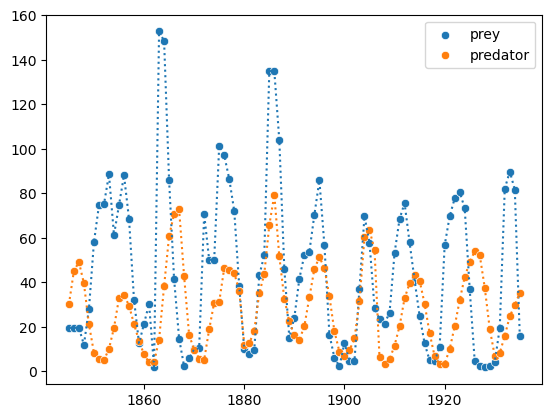

In [2]:
_, fetch = load_dataset(LYNXHARE, shuffle=False)
t, n = fetch()

sns.scatterplot(x = t, y = n[:, 0], label = 'prey')
sns.lineplot(x = t, y = n[:, 0], linestyle = 'dotted')
sns.scatterplot(x = t, y = n[:, 1], label = 'predator')
sns.lineplot(x = t, y = n[:, 1], linestyle = 'dotted')


### Define statistical model

In [3]:
def dn_dt(n, t, n_eq, theta):

    u = n[0]
    v = n[1]

    v_eq = n_eq[0] # v_eq = alpha / beta
    u_eq = n_eq[1] # u_eq = gamma / delta

    beta = theta[0]
    delta = theta[1]

    du_dt = (v_eq - v) * beta * u
    dv_dt = (u - u_eq) * delta * v

    return jax.numpy.stack([du_dt, dv_dt])

def model(t, n, N):

    n_eq = numpyro.sample("n_eq", dist.LogNormal(jax.numpy.log(30.), 0.5).expand([2]))
    theta = numpyro.sample('theta', dist.HalfNormal(0.1).expand([2]))

    n0 = numpyro.sample("n0", dist.LogNormal(jax.numpy.log(30.), 0.5).expand([2]))
    n_mean = odeint(dn_dt, n0, t, n_eq, theta, rtol = 1e-6, atol = 1e-5, mxstep = 1000)

    scale = numpyro.sample("scale", dist.HalfCauchy(10.).expand([2]))
    numpyro.sample("n", dist.Gamma(n_mean / scale, 1. / scale), obs = n)


In [4]:
iter_warmup = 1000
iter_sample = 1000
n_chain = 4

t_scaled = t.astype(float) - min(t.astype(float))

numpyro.set_host_device_count(n_chain)
nuts_kernel = numpyro.infer.NUTS(model, adapt_step_size = True, init_strategy = numpyro.infer.init_to_sample())

mcmc = numpyro.infer.MCMC(nuts_kernel, num_warmup = iter_warmup, num_samples = iter_sample,
                          num_chains = n_chain, chain_method = 'parallel')


/tmp/ipykernel_4843/4207707169.py:10: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts_kernel, num_warmup = iter_warmup, num_samples = iter_sample,


### Warmup

In [5]:
mcmc.warmup(jax.random.PRNGKey(0), t = t_scaled, n = n, N = n.shape[0], collect_warmup = True)

warmup: 100%|██████████| 1000/1000 [01:21<00:00, 12.35it/s, 31 steps of size 1.10e-02. acc. prob=0.79] 


array([[<AxesSubplot: title={'center': 'n0'}>,
        <AxesSubplot: title={'center': 'n0'}>],
       [<AxesSubplot: title={'center': 'n_eq'}>,
        <AxesSubplot: title={'center': 'n_eq'}>],
       [<AxesSubplot: title={'center': 'scale'}>,
        <AxesSubplot: title={'center': 'scale'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

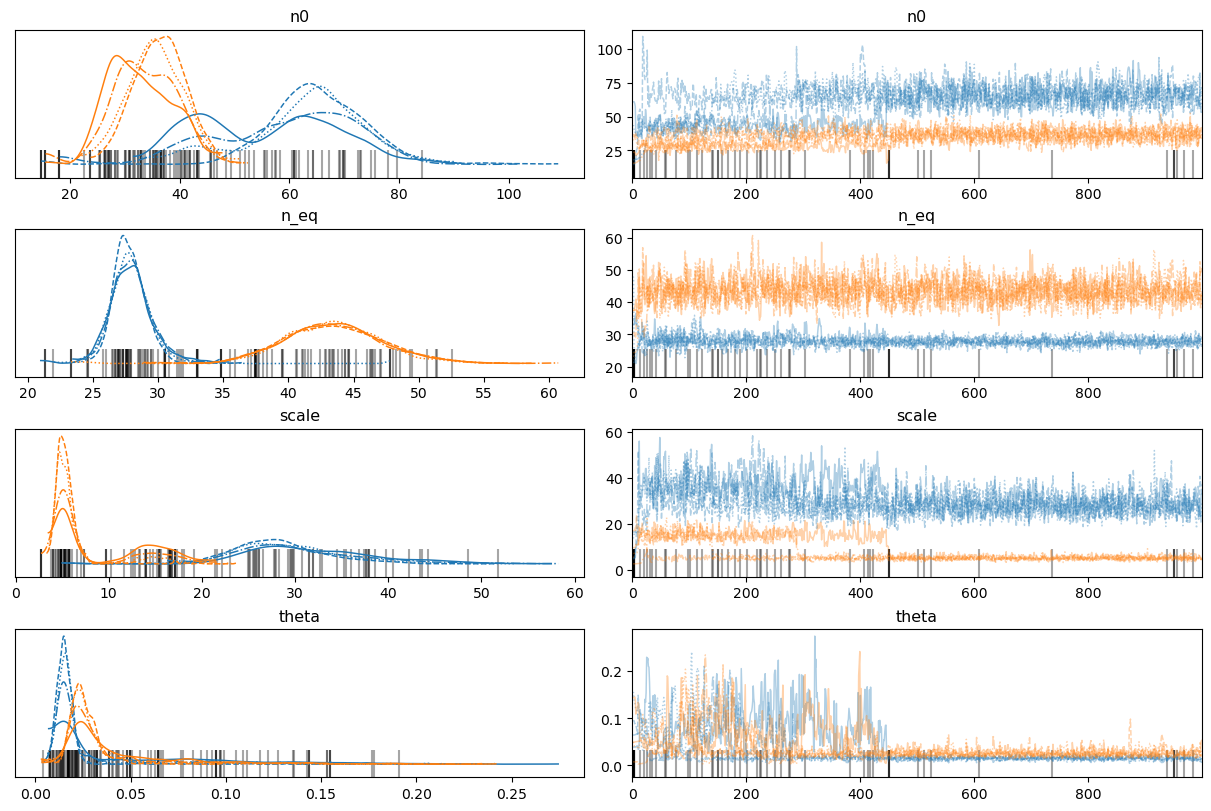

In [6]:
az.plot_trace(mcmc, backend_kwargs = {'constrained_layout': True})

### Run MCMC

In [7]:
mcmc.run(jax.random.PRNGKey(0), t = t_scaled, n = n, N = n.shape[0])

sample: 100%|██████████| 1000/1000 [01:10<00:00, 14.16it/s, 255 steps of size 1.10e-02. acc. prob=0.94]


### Plot posteriors

array([[<AxesSubplot: title={'center': 'n0'}>,
        <AxesSubplot: title={'center': 'n0'}>],
       [<AxesSubplot: title={'center': 'n_eq'}>,
        <AxesSubplot: title={'center': 'n_eq'}>],
       [<AxesSubplot: title={'center': 'scale'}>,
        <AxesSubplot: title={'center': 'scale'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

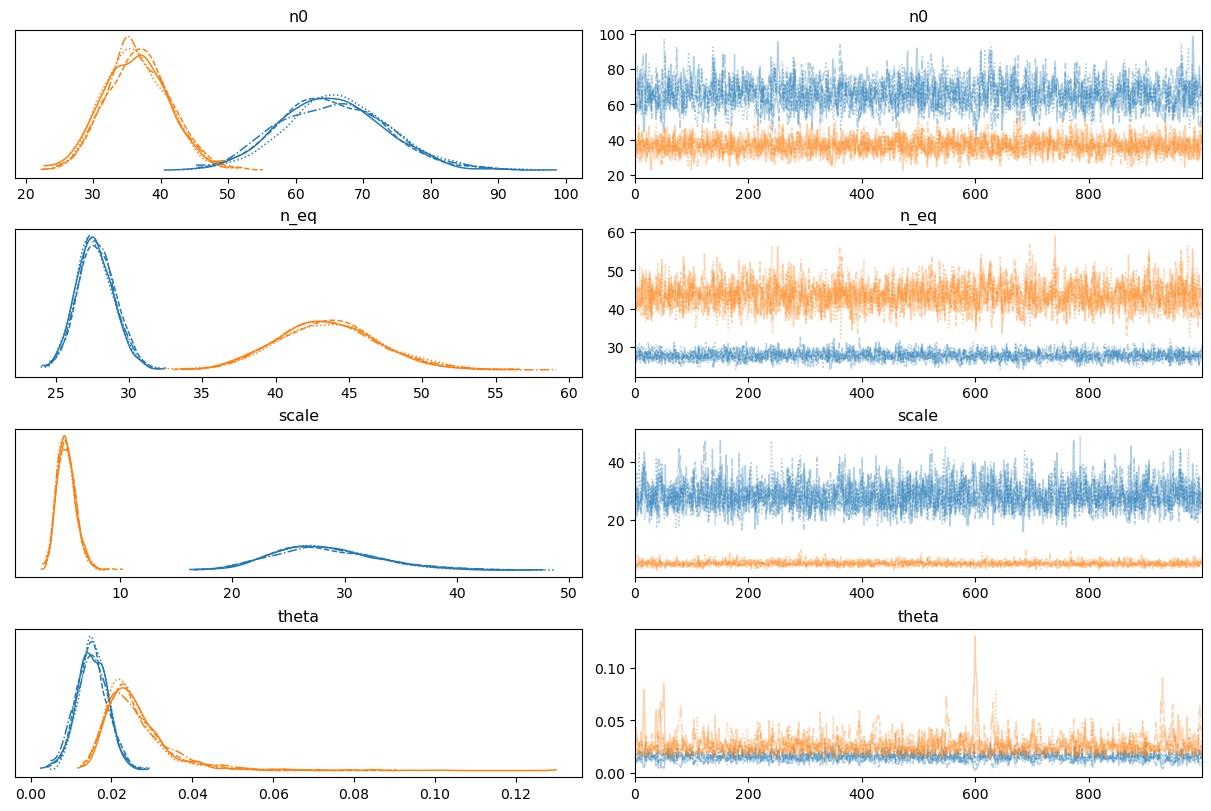

In [8]:
az.plot_trace(mcmc, backend_kwargs = {'constrained_layout': True})

### Get summary statistics

In [9]:
dict_diagnostics = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain = True), prob = 0.95, group_by_chain = True)
df_diagnostics = pd.DataFrame.from_dict(dict_diagnostics)

df_diagnostics

,n0,n_eq,scale,theta
mean,"[65.86752, 36.490776]","[27.73709, 43.623703]","[28.366909, 5.254432]","[0.015248632, 0.026015706]"
std,"[8.023738, 4.7475266]","[1.2649405, 3.466688]","[4.699551, 0.8413031]","[0.0038124628, 0.008555903]"
median,"[65.5934, 36.321983]","[27.67305, 43.53044]","[27.868898, 5.1794376]","[0.015138591, 0.0241265]"
2.5%,"[49.668476, 27.801744]","[25.355091, 36.749603]","[19.90393, 3.765313]","[0.0078132525, 0.014782389]"
97.5%,"[80.83664, 46.06517]","[30.255262, 50.261562]","[37.85881, 6.974107]","[0.022760717, 0.04286416]"
n_eff,"[1438.6778269787133, 2273.089790753873]","[2315.890650591927, 2066.262944864207]","[2259.3559019235563, 2527.515690156155]","[1426.1730586272931, 904.7580025283323]"
r_hat,"[1.0015785, 1.0019011]","[1.0023531, 1.0001634]","[1.0007294, 1.0013108]","[1.0018866, 1.0033603]"


### Generate predictive distribution

In [10]:
pred = numpyro.infer.Predictive(model, mcmc.get_samples(group_by_chain = False))

n_bin = 1000
t_pred_scaled = np.linspace(0, max(t_scaled), n_bin)
t_pred = t_pred_scaled + min(t)

n_pred = pred(jax.random.PRNGKey(0), t = t_pred_scaled, n = None, N = t_pred_scaled.shape[0])['n']

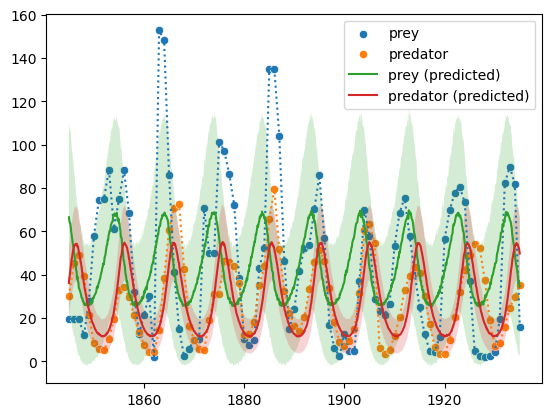

In [11]:
n_pred_mean = n_pred.mean(0)
n_pred_std = n_pred.std(0)

sns.scatterplot(x = t, y = n[:, 0], label = 'prey')
sns.lineplot(x = t, y = n[:, 0], linestyle = 'dotted')
sns.scatterplot(x = t, y = n[:, 1], label = 'predator')
sns.lineplot(x = t, y = n[:, 1], linestyle = 'dotted')
sns.lineplot(x = t_pred, y = n_pred_mean[:, 0], label = 'prey (predicted)')
sns.lineplot(x = t_pred, y = n_pred_mean[:, 1], label = 'predator (predicted)')
plt.fill_between(x = t_pred,
                 y1 = n_pred_mean[:, 0] - n_pred_std[:, 0],
                 y2 = n_pred_mean[:, 0] + n_pred_std[:, 0],
                 alpha = 0.2)
plt.fill_between(x = t_pred,
                 y1 = n_pred_mean[:, 1] - n_pred_std[:, 1],
                 y2 = n_pred_mean[:, 1] + n_pred_std[:, 1],
                 alpha = 0.2)
